In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
max_iters = 300
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.1

'''batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 256  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2'''
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
#with open('input_sp0.txt', 'r', encoding='utf-8') as f:
with open('input0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):  # the heads handle the attention - the communication between the nodes (tokens)
    """ one head of self-attention """

    def __init__(self, head_size):  # takes headsize
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)  # k,q,v like above
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)  # values are affine projections of the original data, the "private data" (key k is "public")
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # tril is not a parameter of the model, a buffer in pytorch lingo
        # (so it does not get picked up by autograd)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)  # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])  # pytorch makes this easy for us, passing just a list of heads
        self.proj = nn.Linear(n_embd, n_embd)  # project back into the original pathway
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # just concatinate the results, concat over channel dimension (dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):  # this handles the per-token (node) computation
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # the inner ff layer has 4 times the embedding dimension (to grow the computation on the residual pathway)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # this is the projection layer going back into the original pathway (for the skip-connection) and going down from 4x
            nn.Dropout(dropout),  # added right before the residual pathway comes back (dropout trains subnetworks by randomly shutting off neurons)
        )

    def forward(self, x):
        return self.net(x)  # this is at a per token level: they think on all the attention data they got individually

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head  # watch out that it works out channelwise (e.g. 32 embedding, 4 heads, 8 headsize)
        self.sa = MultiHeadAttention(n_head, head_size)  # the heads running in parallel - the communication
        self.ffwd = FeedFoward(n_embd)  # simple feedforward: at token level, all tokens do this independently: gathered all info from attention, think on it
        # the ff does the computations
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):  # with skip connection, forking off direct gradient pass-through and block adjustments
        x = x + self.sa(self.ln1(x))  # the x + is the skip connection: it lets the gradient pass through (particularly initially), then the blocks adjust
        x = x + self.ffwd(self.ln2(x))  # note that the layer norms are applied before it goes into self-attention or ff, per token
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # now the network starts to get really deep: suffers from computation problems, two ways to address this: (see Add & Norm in the figure)
        # 1. skip (residual) connections, see https://github.com/KaimingHe/deep-residual-networks (lets gradients pass through and lets blocks adjust them gradually)
        # 2. layer norms = Norm: similar to batch normalization: ensure each neuron has unit Gaussian distribution accross batch dimension
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm (now it is more common to norm before the computations unlike in the trafo paper - called prenorm)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens (idx also has the PE so we need to crop) (not doing this causes a CUDA error due to index out of bounds)
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.205988 M parameters
step 0: train loss 3.7394, val loss 3.7334
step 100: train loss 1.4619, val loss 1.4596
step 200: train loss 0.4608, val loss 0.4622
step 299: train loss 0.1918, val loss 0.1942
 ctyFltayVen RunCowl SwiftBreeze SpriftBreashStream Ventreckent Runt SprintFlatiow SprboHod Rurbod AezerodSperintze shocowl AeroRun Speeel AirSwirinRushCowl BlazeHoodSpeHodStBl Swideeeee AtrroFlow Rung BloiftBlazee Spree AeriroFloFlow Runt SpepridVentt Blowift Blarezen Ae Rushorerocint AeroRunt eroRun Blat keze SpridVent BrintFlow Rung Sprintiftila Turbeze DaspocilashCoch AeroRunt SpriRunJed Spridduntowlaze Sprift Aerirbomt RuntBrboFloHood Blaze SpedeedStriVentStrintFlowlow TurboHod AeroRunt Speridede scunedVent yVelonCowl Aerowl SwiftBrereze Run AeroRun SpirSprint Sprintwideeze oFlow TurowarboHoDapush RunlauninCowl Ka Tuzlapochnen Kat Kaen Kauben sport RufhCoot reerect cowl drung SwniftBlazeHood Speee AerodVent DashCtrowl RunCowl KasBlapeeedry tauft schnedronilay stydry sckedrydry laun st

In [4]:
# increase input text file length

with open('input_sp0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text += ' ' + text

# Writing to file
with open("input_sp1.txt", "w") as f:
    # Writing data to a file
    f.write(text)


In [ ]:
# with double the file length there is barely any overfitting

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input_sp1.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):  # the heads handle the attention - the communication between the nodes (tokens)
    """ one head of self-attention """

    def __init__(self, head_size):  # takes headsize
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)  # k,q,v like above
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # tril is not a parameter of the model, a buffer in pytorch lingo
        # (so it does not get picked up by autograd)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)  # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])  # pytorch makes this easy for us, passing just a list of heads
        self.proj = nn.Linear(n_embd, n_embd)  # project back into the original pathway
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # just concatinate the results, concat over channel dimension (dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):  # this handles the per-token (node) computation
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # the inner ff layer has 4 times the embedding dimension (to grow the computation on the residual pathway)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # this is the projection layer going back into the original pathway (for the skip-connection) and going down from 4x
            nn.Dropout(dropout),  # added right before the residual pathway comes back (dropout trains subnetworks by randomly shutting off neurons)
        )

    def forward(self, x):
        return self.net(x)  # this is at a per token level: they think on all the attention data they got individually

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head  # watch out that it works out channelwise (e.g. 32 embedding, 4 heads, 8 headsize)
        self.sa = MultiHeadAttention(n_head, head_size)  # the heads running in parallel - the communication
        self.ffwd = FeedFoward(n_embd)  # simple feedforward: at token level, all tokens do this independently: gathered all info from attention, think on it
        # the ff does the computations
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):  # with skip connection, forking off direct gradient pass-through and block adjustments
        x = x + self.sa(self.ln1(x))  # the x + is the skip connection: it lets the gradient pass through (particularly initially), then the blocks adjust
        x = x + self.ffwd(self.ln2(x))  # note that the layer norms are applied before it goes into self-attention or ff, per token
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # now the network starts to get really deep: suffers from computation problems, two ways to address this: (see Add & Norm in the figure)
        # 1. skip (residual) connections, see https://github.com/KaimingHe/deep-residual-networks (lets gradients pass through and lets blocks adjust them gradually)
        # 2. layer norms = Norm: similar to batch normalization: ensure each neuron has unit Gaussian distribution accross batch dimension
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm (now it is more common to norm before the computations unlike in the trafo paper - called prenorm)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens (idx also has the PE so we need to crop) (not doing this causes a CUDA error due to index out of bounds)
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.4086, val loss 4.4042
step 100: train loss 2.6523, val loss 2.6555
step 200: train loss 2.4994, val loss 2.5055
step 300: train loss 2.4131, val loss 2.4304
step 400: train loss 2.3452, val loss 2.3614
step 500: train loss 2.3022, val loss 2.3056
step 600: train loss 2.2582, val loss 2.2726
step 700: train loss 2.1969, val loss 2.2117
step 800: train loss 2.1801, val loss 2.1993
step 900: train loss 2.1333, val loss 2.1499
step 1000: train loss 2.1000, val loss 2.1186
step 1100: train loss 2.0730, val loss 2.0943
step 1200: train loss 2.0477, val loss 2.0648
step 1300: train loss 2.0169, val loss 2.0488
step 1400: train loss 1.9951, val loss 2.0256
step 1500: train loss 1.9823, val loss 2.0090
step 1600: train loss 1.9570, val loss 1.9924
step 1700: train loss 1.9489, val loss 1.9794
step 1800: train loss 1.9309, val loss 1.9527
step 1900: train loss 1.9167, val loss 1.9405
step 2000: train loss 1.9054, val loss 1.9344
step 2100: train loss 1.

In [7]:
# byte-pair encoding
# https://ufal.mff.cuni.cz/~helcl/courses/npfl116/ipython/byte_pair_encoding.html

import re, collections

def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out



In [29]:
from IPython.display import display, Markdown, Latex

train_data = {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}  # word: frequency

bpe_codes = {}
bpe_codes_reverse = {}

num_merges = 15

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(train_data)
    best = max(pairs, key=pairs.get)
    train_data = merge_vocab(best, train_data)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    print("new merge: {}".format(best))
    print("train data: {}".format(train_data))

print(bpe_codes)

### Iteration 1

new merge: ('e', 's')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

new merge: ('es', 't')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

new merge: ('est', '</w>')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

new merge: ('l', 'o')
train data: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

new merge: ('lo', 'w')
train data: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

new merge: ('n', 'e')
train data: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

new merge: ('ne', 'w')
train data: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

new merge: ('new', 'est</w>')
train data: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

new merge: ('low', '</w>')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

new merge: ('w', 'i')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


### Iteration 11

new merge: ('wi', 'd')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wid est</w>': 3}


### Iteration 12

new merge: ('wid', 'est</w>')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'widest</w>': 3}


### Iteration 13

new merge: ('low', 'e')
train data: {'low</w>': 5, 'lowe r </w>': 2, 'newest</w>': 6, 'widest</w>': 3}


### Iteration 14

new merge: ('lowe', 'r')
train data: {'low</w>': 5, 'lower </w>': 2, 'newest</w>': 6, 'widest</w>': 3}


### Iteration 15

new merge: ('lower', '</w>')
train data: {'low</w>': 5, 'lower</w>': 2, 'newest</w>': 6, 'widest</w>': 3}
{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9, ('wi', 'd'): 10, ('wid', 'est</w>'): 11, ('low', 'e'): 12, ('lowe', 'r'): 13, ('lower', '</w>'): 14}


In [9]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))

    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))
        
        print("bigrams in the word: {}".format(pairs))
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # don't print end-of-word symbols
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)
   
    return word

In [10]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('s', 't'), ('o', 'w'), ('e', 's'), ('w', 'e'), ('t', '</w>'), ('l', 'o')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')


__Iteration 2:__

bigrams in the word: {('o', 'w'), ('w', 'es'), ('es', 't'), ('t', '</w>'), ('l', 'o')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')


__Iteration 3:__

bigrams in the word: {('est', '</w>'), ('o', 'w'), ('l', 'o'), ('w', 'est')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')


__Iteration 4:__

bigrams in the word: {('o', 'w'), ('l', 'o'), ('w', 'est</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')


__Iteration 5:__

bigrams in the word: {('w', 'est</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')


__Iteration 6:__

bigrams in the word: {('low', 'est</w>')}
candidate for merging: ('low', 'est</w>')


__Candidate not in BPE merges, algorithm stops.__

('low', 'est')

In [11]:
bpe_codes

{('e', 's'): 0,
 ('es', 't'): 1,
 ('est', '</w>'): 2,
 ('l', 'o'): 3,
 ('lo', 'w'): 4,
 ('n', 'e'): 5,
 ('ne', 'w'): 6,
 ('new', 'est</w>'): 7,
 ('low', '</w>'): 8,
 ('w', 'i'): 9,
 ('wi', 'd'): 10,
 ('wid', 'est</w>'): 11,
 ('low', 'e'): 12,
 ('lowe', 'r'): 13,
 ('lower', '</w>'): 14}

In [2]:
# BPE w/o output
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs
    

def encode_bp(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        if bigram not in bpe_codes:
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # don't print end-of-word symbols
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)
   
    return word
    

In [36]:
encode_bp("lowest")

('l', 'o', 'w', 'es', 't')

In [55]:
# train BPE with our input text
import re, collections

def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

with open('inp_testbpe0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'[^\w]', ' ', text)  # remove all symbols

text = text.replace('\n', ' ')
words = sorted(list(set(text.lower().split(' '))))
wordfreq = {w: text.count(w) for w in words}
#print(words)
print(wordfreq)

#print({(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))})

#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))}
#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(words)}
#train_data = {(v + '</w>'):idx for idx,v in enumerate(words)}
#train_data = {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
#train_data = wordfreq
train_data = {(' '.join([el for el in key]) + ' </w>'):val for key,val in wordfreq.items()}
print(train_data)
#print(get_stats(train_data))

bpe_codes = {}
bpe_codes_reverse = {}

#num_merges = length of word l, length of subword n: l! / (n!(l-n)!) --> sum for n=1 to l = 2**l - 1 + number of words
# average word length
avrgwordlen = sum([len(w) for w in words]) / len(words)
num_merges = 2**int(avrgwordlen+1) - 1 + len(words)
# simpler: number of words * 2 seems to work just as well
#num_merges = 2*len(words)
print(f"numer of words: {len(words)} avrg word length: {avrgwordlen} --> number of merges: {num_merges}")

for i in range(num_merges):
    #print("### Iteration {}".format(i + 1))
    pairs = get_stats(train_data)
    best = max(pairs, key = pairs.get)
    train_data = merge_vocab(best, train_data)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    #print("new merge: {}".format(best))
    #print("train data: {}".format(train_data))

print(bpe_codes)
print()

#for word in words:
encodedlen = 0
for word in text.split(' '):
    wordencoded = encode_bp(word.lower())
    print(f"word: {word} --> {wordencoded}")
    encodedlen += len(wordencoded)

print(encodedlen / len(text.split(' ')))

{'': 1137, 'a': 53, 'abundance': 1, 'account': 2, 'accounted': 1, 'accusations': 1, 'afflicts': 1, 'altitude': 1, 'an': 9, 'and': 1, 'are': 3, 'as': 3, 'authority': 1, 'barren': 1, 'be': 4, 'become': 1, 'bread': 1, 'but': 2, 'can': 2, 'cannot': 1, 'capitol': 0, 'citizen': 1, 'citizens': 1, 'city': 1, 'conscienced': 1, 'content': 1, 'country': 1, 'covetous': 1, 'dear': 1, 'did': 2, 'done': 1, 'end': 1, 'ere': 3, 'even': 3, 'famously': 1, 'faults': 1, 'first': 0, 'for': 4, 'gain': 1, 'gods': 1, 'good': 1, 'guess': 1, 'hath': 2, 'he': 26, 'help': 1, 'here': 1, 'him': 1, 'his': 6, 'humanely': 1, 'hunger': 1, 'i': 75, 'if': 1, 'in': 10, 'inventory': 1, 'is': 14, 'it': 18, 'know': 1, 'leanness': 1, 'let': 0, 'men': 1, 'might': 1, 'misery': 1, 'mother': 1, 'must': 2, 'nature': 1, 'need': 1, 'no': 6, 'not': 4, 'o': 64, 'object': 1, 'of': 4, 'on': 7, 'other': 2, 'our': 3, 'particularise': 1, 'partly': 1, 'patricians': 1, 'pikes': 1, 'please': 1, 'poor': 1, 'prating': 1, 'proud': 1, 'rakes': 1, 

In [40]:
encode('migrate')

__word split into characters:__ <tt>('m', 'i', 'g', 'r', 'a', 't', 'e', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('i', 'g'), ('t', 'e'), ('m', 'i'), ('e', '</w>'), ('a', 't'), ('g', 'r'), ('r', 'a')}
candidate for merging: ('e', '</w>')
word after merging: ('m', 'i', 'g', 'r', 'a', 't', 'e</w>')


__Iteration 2:__

bigrams in the word: {('i', 'g'), ('m', 'i'), ('a', 't'), ('g', 'r'), ('r', 'a'), ('t', 'e</w>')}
candidate for merging: ('m', 'i')
word after merging: ('mi', 'g', 'r', 'a', 't', 'e</w>')


__Iteration 3:__

bigrams in the word: {('mi', 'g'), ('a', 't'), ('g', 'r'), ('r', 'a'), ('t', 'e</w>')}
candidate for merging: ('mi', 'g')


__Candidate not in BPE merges, algorithm stops.__

('mi', 'g', 'r', 'a', 't', 'e')

In [41]:
# how to integrate BPE into the LM?



# next steps:
# - implement positional encoding via sin/cos
# - test iterative transformer (i.e. iterative self-attention)

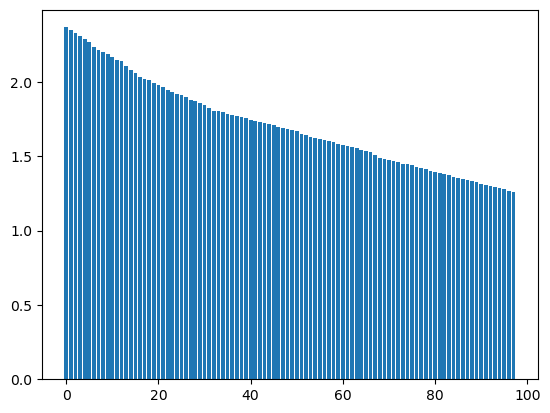

In [5]:
# test number of merges 
import re, collections
import matplotlib.pyplot as plt
import numpy as np

def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

with open('inp_testbpe0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'[^\w]', ' ', text)  # remove all symbols

text = text.replace('\n', ' ')
words = sorted(list(set(text.lower().split(' '))))
wordfreq = {w: text.count(w) for w in words}


y = []

for num_merges in range(len(words)//2, 2*len(words), 2):
    
    train_data = {(' '.join([el for el in key]) + ' </w>'):val for key,val in wordfreq.items()}
    
    bpe_codes = {}
    bpe_codes_reverse = {}
    
    for i in range(num_merges):
        #print("### Iteration {}".format(i + 1))
        pairs = get_stats(train_data)
        best = max(pairs, key = pairs.get)
        train_data = merge_vocab(best, train_data)
        
        bpe_codes[best] = i
        bpe_codes_reverse[best[0] + best[1]] = best
        
        #print("new merge: {}".format(best))
        #print("train data: {}".format(train_data))
    
    #print(bpe_codes)
    #print()
    
    #for word in words:
    encodedlen = 0
    for word in text.split(' '):
        wordencoded = encode_bp(word.lower())
        #print(f"word: {word} --> {wordencoded}")
        encodedlen += len(wordencoded)
    
    #print(encodedlen / len(text.split(' ')))
    y.append(encodedlen / len(text.split(' ')))


x = np.arange(len(y))
plt.bar(x, height=y)
plt.show()

In [25]:
# train BPE and build symbolic embedding - test
import re, collections
import math


def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

with open('inp_testbpe0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'[^\w]', ' ', text)  # remove all symbols

text = text.replace('\n', ' ')
words = sorted(list(set(text.lower().split(' '))))
wordfreq = {w: text.count(w) for w in words}
#print(words)
#print(wordfreq)

#print({(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))})

#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))}
#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(words)}
#train_data = {(v + '</w>'):idx for idx,v in enumerate(words)}
#train_data = {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
#train_data = wordfreq
train_data = {(' '.join([el for el in key]) + ' </w>'):val for key,val in wordfreq.items()}
#print(train_data)
#print(get_stats(train_data))

bpe_codes = {}
bpe_codes_reverse = {}

#num_merges = length of word l, length of subword n: l! / (n!(l-n)!) --> sum for n=1 to l = 2**l - 1 + number of words
# average word length
avrgwordlen = sum([len(w) for w in words]) / len(words)
num_merges = 2**int(avrgwordlen+1) - 1 + len(words)
# simpler: number of words * 2 seems to work just as well
#num_merges = 2*len(words)
print(f"numer of words: {len(words)} avrg word length: {avrgwordlen} --> number of merges: {num_merges}")
print()

for i in range(num_merges):
    #print("### Iteration {}".format(i + 1))
    pairs = get_stats(train_data)
    best = max(pairs, key = pairs.get)
    train_data = merge_vocab(best, train_data)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    #print("new merge: {}".format(best))
    #print("train data: {}".format(train_data))

#print(bpe_codes)
#print()

bpesymbols = set()
textencoded = []

for word in text.split(' '):
    wordencoded = encode_bp(word.lower())
    for s in wordencoded:
        textencoded.append(s)
    textencoded.append('</w>')
    #print(f"word: {word} --> {wordencoded}")
    for w in wordencoded:
        bpesymbols.add(w)

#bpesymbols.add('</w>')

bpetoi = { symb:i for i, symb in enumerate(bpesymbols) }
bpetoi['</w>'] = math.inf
print(bpetoi)

textbpesymb = [bpetoi[s] for s in textencoded]
print(textbpesymb)

numer of words: 130 avrg word length: 4.946153846153846 --> number of merges: 161

{'de': 0, 'ly': 1, 'for': 2, 'at': 3, 'th': 4, 'that': 5, 'authority': 6, 'abundance': 7, 'mi': 8, 'the': 9, 'say': 10, 'be': 11, 'you': 12, 'kes': 13, 'us': 14, 'a': 15, 'ty': 16, 'revenge': 17, 'ng': 18, 'account': 19, 'c': 20, 'become': 21, 'u': 22, 'ere': 23, 'ti': 24, 'b': 25, 'afflicts': 26, 'are': 27, 'whi': 28, 'k': 29, 'no': 30, 'oun': 31, 'au': 32, 'm': 33, 'our': 34, 'accusations': 35, 'go': 36, 'e': 37, 'o': 38, 'ea': 39, 'in': 40, 'ts': 41, 'as': 42, 'gh': 43, 'must': 44, 'p': 45, 'an': 46, 'n': 47, 'it': 48, 'did': 49, 'w': 50, 'hath': 51, 'h': 52, 'v': 53, 'pe': 54, 'ay': 55, 'citiz': 56, 't': 57, 'ce': 58, 'pl': 59, 'ati': 60, 'relieve': 61, 'other': 62, 'even': 63, 'barren': 64, 'l': 65, 's': 66, 'g': 67, 'su': 68, 'ance': 69, 'par': 70, 'this': 71, 'we': 72, 'rf': 73, 'eve': 74, 'of': 75, 'with': 76, 'ir': 77, 'ff': 78, 'wh': 79, 'se': 80, 'on': 81, 'or': 82, 'and': 83, 'ome': 84, 'he':

In [145]:
# positional encoding
import numpy as np
import math

positions = np.arange(4)
print(positions/4)  # unique values
positions = np.arange(8)
print(positions/4)  # unique but > 1

positions = np.arange(8)
print(np.remainder(positions, 4)/4)  # <1 but not unique

positions = np.arange(8)
positionvectors = np.ones(8) * np.array([np.remainder(positions, 4)/4, np.remainder(positions, 5)/5, np.remainder(positions, 7)/7])
print(positionvectors.T)
print()

print(np.linalg.norm(positionvectors.T[3] - positionvectors.T[2]))  # distances not equal
print(np.linalg.norm(positionvectors.T[4] - positionvectors.T[3]))

#print(positionvectors.T * np.deg2rad(360))  # angles
print()

print(f"sin: {np.sin(positionvectors.T * np.deg2rad(360))}")  # xy coordinates
print(f"cos: {np.cos(positionvectors.T * np.deg2rad(360))}")
print()

positionvectorssin = np.array([[np.sin(v[i]) for v in positionvectors.T * np.deg2rad(360)] for i in range(3)])
positionvectorscos = np.array([[np.cos(v[i]) for v in positionvectors.T * np.deg2rad(360)] for i in range(3)])

row_a, col_a = np.shape(positionvectorssin)
positionvectorsxy = np.ravel([positionvectorssin, positionvectorscos], order="F")
#positionvectorsxy = np.reshape(positionvectorsxy, (2*row_a, col_a))
positionvectorsxy = np.array([positionvectorsxy.tolist()[i:i+2*row_a] for i in range(0, 2*row_a*col_a, 2*row_a)])
print(positionvectorsxy.T)
print()

print(np.linalg.norm(positionvectorsxy.T[0:, 3] - positionvectorsxy.T[0:, 2]))  # distances are now equal
print(np.linalg.norm(positionvectorsxy.T[0:, 4] - positionvectorsxy.T[0:, 3]))


[0.   0.25 0.5  0.75]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]
[0.   0.25 0.5  0.75 0.   0.25 0.5  0.75]
[[0.         0.         0.        ]
 [0.25       0.2        0.14285714]
 [0.5        0.4        0.28571429]
 [0.75       0.6        0.42857143]
 [0.         0.8        0.57142857]
 [0.25       0.         0.71428571]
 [0.5        0.2        0.85714286]
 [0.75       0.4        0.        ]]

0.3505826054802293
0.7892453124759793

sin: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  9.51056516e-01  7.81831482e-01]
 [ 1.22464680e-16  5.87785252e-01  9.74927912e-01]
 [-1.00000000e+00 -5.87785252e-01  4.33883739e-01]
 [ 0.00000000e+00 -9.51056516e-01 -4.33883739e-01]
 [ 1.00000000e+00  0.00000000e+00 -9.74927912e-01]
 [ 1.22464680e-16  9.51056516e-01 -7.81831482e-01]
 [-1.00000000e+00  5.87785252e-01  0.00000000e+00]]
cos: [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 6.12323400e-17  3.09016994e-01  6.23489802e-01]
 [-1.00000000e+00 -8.09016994e-01 -2.2252093

In [184]:
# https://helsinki-nlp.github.io/shroom/
10.179/7.914

1.2862016679302504

In [165]:
import torch
import numpy as np

max_len = 10
d_model = 8
position = torch.arange(0, max_len).float().unsqueeze(1)  # https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch

angular_speed = torch.exp(
    torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
)
encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

print(np.round(encoding[0:4], 4))


tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])


In [4]:
# layer normalization
import torch
import torch.nn as nn

dmodel = 4
seqlen = 2
npoints = 3

torch.manual_seed(34)
data = torch.randn(npoints, seqlen, dmodel)  # note (N, L, D)
print(data)

datamean = data.mean(axis=2).unsqueeze(2)
print(datamean)

datavar = data.var(axis=2, unbiased=False).unsqueeze(2)
print(datavar)

print((data - datamean) / torch.sqrt(datavar + 1e-5))

layernorm = nn.LayerNorm(dmodel)  # this is the same
normalized = layernorm(data)

print(normalized)

tensor([[[-1.9024,  0.4950, -0.8662,  0.5679],
         [ 0.4720,  0.1376,  0.0508, -1.3710]],

        [[-1.2136,  0.1780,  1.4307,  0.5042],
         [-0.9384, -0.9085, -1.1091, -0.8476]],

        [[-0.4022,  0.4854,  1.6852,  0.5294],
         [ 1.6921,  3.2086,  0.7335,  0.5381]]])
tensor([[[-0.4264],
         [-0.1776]],

        [[ 0.2248],
         [-0.9509]],

        [[ 0.5744],
         [ 1.5431]]])
tensor([[[1.0524],
         [0.4994]],

        [[0.9009],
         [0.0094]],

        [[0.5494],
         [1.1154]]])
tensor([[[-1.4387,  0.8982, -0.4287,  0.9693],
         [ 0.9193,  0.4461,  0.3233, -1.6886]],

        [[-1.5155, -0.0494,  1.2705,  0.2943],
         [ 0.1286,  0.4370, -1.6297,  1.0641]],

        [[-1.3176, -0.1202,  1.4986, -0.0608],
         [ 0.1411,  1.5770, -0.7666, -0.9515]]])
tensor([[[-1.4387,  0.8982, -0.4287,  0.9693],
         [ 0.9193,  0.4461,  0.3233, -1.6886]],

        [[-1.5155, -0.0494,  1.2705,  0.2943],
         [ 0.1286,  0.4370, -1.6297

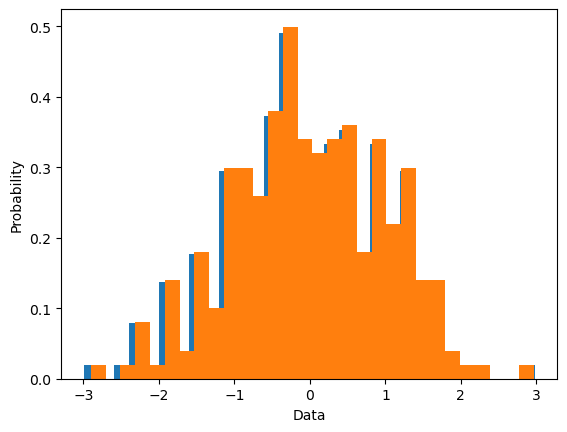

In [12]:
# batch normalization
# batch 0 |-------------------- -> layer norm (horizontal)
#         |--------------------
#         |-> batch norm batch 0 (vertical by batch)
# batch 1 |--------------------
#         |--------------------
#         |-> batch norm batch 1  
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#np.random.seed(42)
#x = np.random.normal(size=1000)

#plt.hist(x, density=True, bins=30)  # density=False would make counts

dmodel = 4
seqlen = 1
npoints = 256

torch.manual_seed(23)
data = torch.randn(npoints, seqlen, dmodel)  # note (N, L, D)
#print(data)

plt.hist([data[i][0][0] for i in range(npoints)], density=True, bins=30)

plt.ylabel('Probability')
plt.xlabel('Data')

layernorm = nn.LayerNorm(npoints)
normalized = layernorm(data[:, 0, 0])
#normalized
plt.hist([normalized.detach().numpy()[i] for i in range(npoints)], density=True, bins=30)

plt.show()

In [2]:
sourceseqenc = torch.tensor([[[1.46, 2.37], [1.98, -0.76]]])
layernorm = nn.LayerNorm(2)
layernorm(sourceseqenc)  # +-1 fortwoe features only

tensor([[[-1.0000,  1.0000],
         [ 1.0000, -1.0000]]], grad_fn=<NativeLayerNormBackward0>)

In [24]:
import math
#import matplotlib.pyplot as plt
#import numpy as np

print(math.sqrt(87), 9+1/3)

def approxsqrt(a):
    aa = int(math.sqrt(a))
    return (aa, a - aa*aa, 2*aa)

#xy = np.array([(a, math.sqrt(a)) for a in range(2,50)])
#plt.scatter(xy[:, 0], xy[:, 1])
#plt.show()

a = 87
r = approxsqrt(a)
print(r, r[0] + r[1]/r[2], math.sqrt(a))
a = 73
r = approxsqrt(a)
print(r, r[0] + r[1]/r[2], math.sqrt(a))
a = 153
r = approxsqrt(a)
print(r, r[0] + r[1]/r[2], math.sqrt(a))
a = 15324556
r = approxsqrt(a)
print(r, r[0] + r[1]/r[2], math.sqrt(a))

9.327379053088816 9.333333333333334
(9, 6, 18) 9.333333333333334 9.327379053088816
(8, 9, 16) 8.5625 8.54400374531753
(12, 9, 24) 12.375 12.36931687685298
(3914, 5160, 7828) 3914.6591722023504 3914.6591167047995


[[ 1.03487506  0.96613817]
 [ 0.80546093 -0.91690943]
 [-0.82507582 -0.94988627]
 [-0.86696831  0.93424827]]


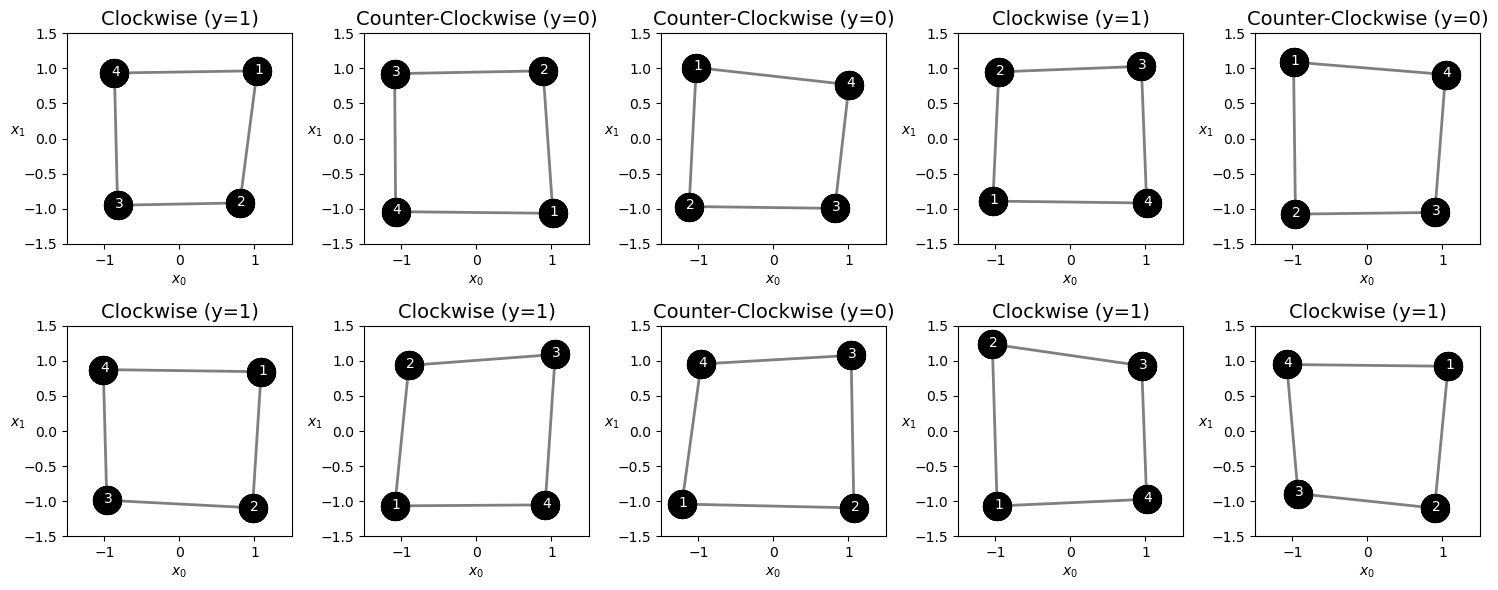

In [34]:
import numpy as np
from matplotlib import pyplot as plt, patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions


def plot_data(points, directions, n_rows=2, n_cols=5):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axs = axs.flatten()
    
    for e, ax in enumerate(axs):
        pred_corners = points[e]
        clockwise = directions[e]
        for i in range(4):
            color = 'k'
            ax.scatter(*pred_corners.T, c=color, s=400)
            if i == 3:
                start = -1
            else:
                start = i
            ax.plot(*pred_corners[[start, start+1]].T, c='k', lw=2, alpha=.5, linestyle='-')
            ax.text(*(pred_corners[i] - np.array([.04, 0.04])), str(i+1), c='w', fontsize=10)
            if directions is not None:
                ax.set_title(f'{"Counter-" if not clockwise else ""}Clockwise (y={clockwise})', fontsize=14)

        ax.set_xlabel(r"$x_0$")
        ax.set_ylabel(r"$x_1$", rotation=0)
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])

    fig.tight_layout()
    return fig

pts, dirs = generate_sequences(n=128, seed=13)
print(pts[0])
fig = plot_data(pts, dirs)

In [17]:
import math

print(math.degrees(math.atan(262/286)), math.degrees(math.atan(262/338)))

42.492298272933745 37.78097917513034


## Hugging Face

https://github.com/nlp-with-transformers/notebooks

In [10]:
# search hub: https://huggingface.co/docs/huggingface_hub/v0.5.1/en/searching-the-hub
#from huggingface_hub import list_datasets
from huggingface_hub import DatasetFilter
from huggingface_hub import DatasetSearchArguments
from huggingface_hub import HfApi

api = HfApi()

#all_datasets = list_datasets()

dataset_args = DatasetSearchArguments()
filt = DatasetFilter(
   #languages=dataset_args.languages.en,
   task_categories=dataset_args.task_categories.text_classification
)
ds = list(api.list_datasets(filter=filt))
first_ds = ds[0]
print(first_ds)
#print(f"currently {len(all_datasets)} available on the Hub")
#print(f"the firsst ten are {all_datasets}")

Dataset Name: ade_corpus_v2, Tags: ['task_categories:text-classification', 'task_categories:token-classification', 'task_ids:coreference-resolution', 'task_ids:fact-checking', 'annotations_creators:expert-generated', 'language_creators:found', 'multilinguality:monolingual', 'size_categories:10K<n<100K', 'size_categories:1K<n<10K', 'size_categories:n<1K', 'source_datasets:original', 'language:en', 'license:unknown', 'region:us']


In [18]:
from datasets import load_dataset

emotions = load_dataset("emotion")

emotions

D:\Anaconda\envs\tf-gpu\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [17]:
train_ds = emotions["train"]
train_ds

NameError: name 'emotions' is not defined

In [20]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [21]:
train_ds.column_names

['text', 'label']

In [22]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [23]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [33]:
print(list(zip(train_ds[:5]["text"], [train_ds.features["label"].names[l] for l in train_ds[:5]["label"]])))

[('i didnt feel humiliated', 'sadness'), ('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'sadness'), ('im grabbing a minute to post i feel greedy wrong', 'anger'), ('i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'love'), ('i am feeling grouchy', 'anger')]


In [19]:
# datasets -> dataframes
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [36]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


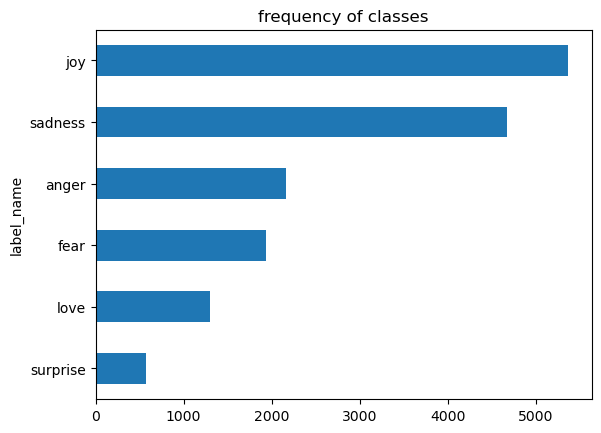

In [38]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("frequency of classes")
plt.show()

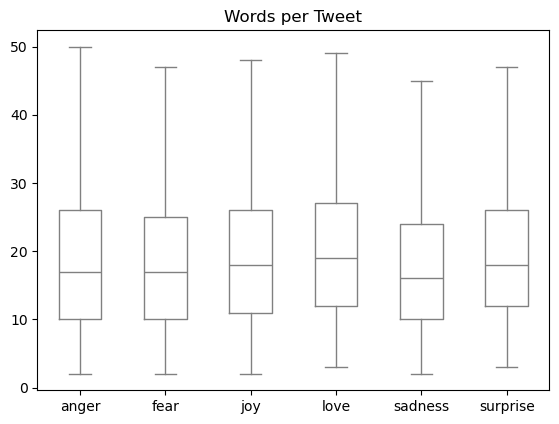

In [41]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False,
          showfliers=False, color="grey")
plt.suptitle('')
plt.xlabel('')
plt.show()

In [24]:

emotions.reset_format()

## Subword tokenization

In [2]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

D:\Anaconda\envs\tf-gpu\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bscho\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [3]:
text = "Follow the installation pages of Flax, PyTorch or TensorFlow to see how to install them with conda. NOTE: On Windows, you may be prompted to activate Developer Mode in order to benefit from caching. If this is not an option for you, please let us know in this issue. All the model checkpoints provided by 🤗 Transformers are seamlessly integrated from the huggingface.co model hub, where they are uploaded directly by users and organizations."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 3582, 1996, 8272, 5530, 1997, 13109, 8528, 1010, 1052, 22123, 2953, 2818, 2030, 23435, 12314, 2000, 2156, 2129, 2000, 16500, 2068, 2007, 9530, 2850, 1012, 3602, 1024, 2006, 3645, 1010, 2017, 2089, 2022, 9469, 2000, 20544, 9722, 5549, 1999, 2344, 2000, 5770, 2013, 6187, 8450, 1012, 2065, 2023, 2003, 2025, 2019, 5724, 2005, 2017, 1010, 3531, 2292, 2149, 2113, 1999, 2023, 3277, 1012, 2035, 1996, 2944, 26520, 2015, 3024, 2011, 100, 19081, 2024, 25180, 10895, 6377, 2013, 1996, 17662, 12172, 1012, 2522, 2944, 9594, 1010, 2073, 2027, 2024, 21345, 3495, 2011, 5198, 1998, 4411, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [21]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'follow', 'the', 'installation', 'pages', 'of', 'fl', '##ax', ',', 'p', '##yt', '##or', '##ch', 'or', 'tensor', '##flow', 'to', 'see', 'how', 'to', 'install', 'them', 'with', 'con', '##da', '.', 'note', ':', 'on', 'windows', ',', 'you', 'may', 'be', 'prompted', 'to', 'activate', 'developer', 'mode', 'in', 'order', 'to', 'benefit', 'from', 'ca', '##ching', '.', 'if', 'this', 'is', 'not', 'an', 'option', 'for', 'you', ',', 'please', 'let', 'us', 'know', 'in', 'this', 'issue', '.', 'all', 'the', 'model', 'checkpoint', '##s', 'provided', 'by', '[UNK]', 'transformers', 'are', 'seam', '##lessly', 'integrated', 'from', 'the', 'hugging', '##face', '.', 'co', 'model', 'hub', ',', 'where', 'they', 'are', 'uploaded', 'directly', 'by', 'users', 'and', 'organizations', '.', '[SEP]']


In [22]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [25]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Feature extraction

In [6]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"input tensor shape: {inputs['input_ids'].size()}")

input tensor shape: torch.Size([1, 6])


In [9]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():  # prevent backprop
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [11]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [12]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [13]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in inputs.items()
             if k in tokenizer.model_input_names}
    with torch.no_grad():  # prevent backprop
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [26]:
# convert to torch format (model takes tensors)
emotions_encoded.set_format("torch",
                           columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

UnboundLocalError: local variable 'inputs' referenced before assignment